In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import matplotlib.ticker as plticker
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from collections import defaultdict
from typing import Optional
from scipy.integrate import solve_ivp
from scipy.fftpack import diff as psdiff
import torch
import pytorch_lightning as pl
from torch import nn

import os, sys
sys.path.append(os.path.join(os.getcwd(), '../sympde'))

from data.dataset import PDEDataset, PDEDataModule
from data.utils import d_to_LT
from misc.utils import load_obj

from model.setup import setup_model
from model.networks.fno import FNO1d
from model.networks.cnn import CNN, ResNet, BasicBlock1d, ResNet_conv
from model.learner import Learner

from model.networks.fno import FNO1d

from viz.plot_pde_data import plot_1ds, plot_1d_dict
from misc.utils import load_obj, save_obj

from run import parse_options, main

from model.networks.single_sym.magnitude import Conv1dMag, Conv2dMag
from misc.equiv import assert_equiv


In [116]:
args = parse_options(notebook=True)
args.train = True
args.pde_name = 'KdV'
args.data_dir = '../data/test'
args.net = 'ResNet'
args.max_epochs = 3
args.batch_size = 4
args.num_workers = 0
args.persistent_workers = False
args.verion = None
args.do_return = True

args.seed = 2
args.epsilons = [0., 0., 0., 0.]

model, trainer, datamodule = main(args)
model.eval();

Seed set to 2
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs




###	Version:  None 	###
###	Name:  datatest_netResNet_equivnone_KdV_aug0.0-0.0-0.0-0.0_seed2 	###


Selecting 10 out of the 10 train samples!
Augmenting KdV with epsilons [0.0, 0.0, 0.0, 0.0]!
Selecting 2 out of the 2 val samples!
Selecting 2 out of the 2 test samples!


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


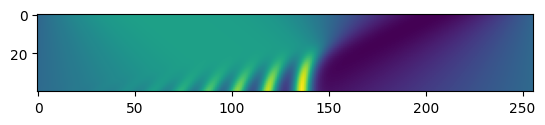

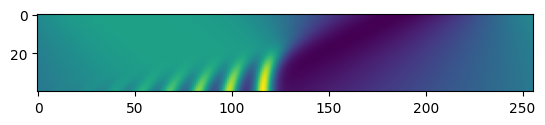

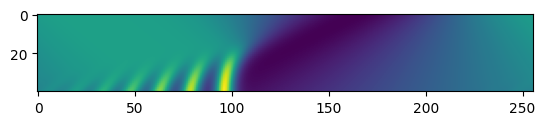

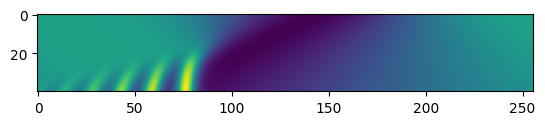

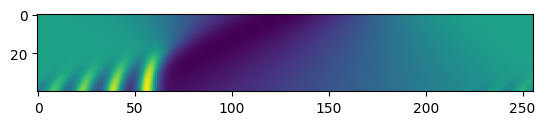

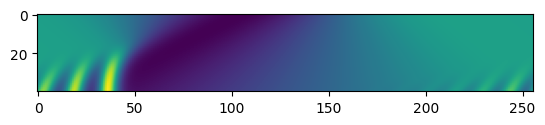

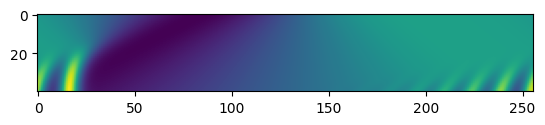

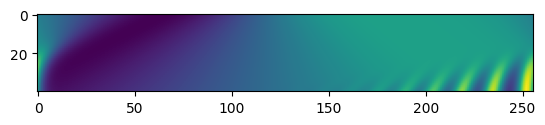

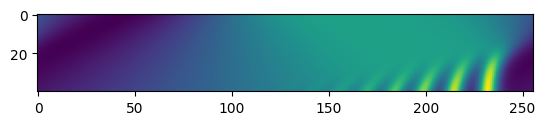

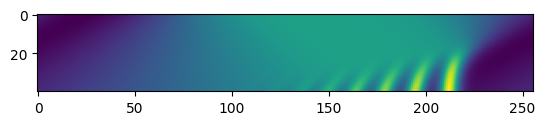

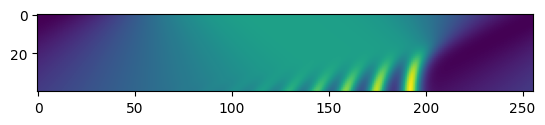

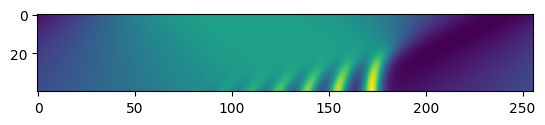

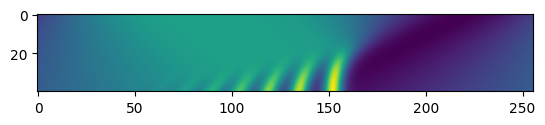

In [150]:
u, dx, dt = batch_i

for space_cut in range(0, 256, 20):
    u_tranfs = torch.cat((u[:, space_cut:], u[:, :space_cut]), axis=1)
    plt.imshow(u_tranfs)
    plt.show()

In [175]:
dataloader = datamodule.train_dataloader()
dataset = datamodule.dataset['train']
batch = us, dxs, dts = next(iter(dataloader))


def augment_none(batch_i, dataset = dataset, epsilons = [0, 0., 0., 0.]):
    assert dataset.epsilons == [0, 0., 0., 0.] == epsilons
    return batch_i

def augment_space(batch_i, dataset = dataset, epsilons = [0, .5, 0., 0.]):
    assert dataset.epsilons == [0, 0., 0., 0.]
    return dataset.augment(*batch_i, epsilons)
    u, dx, dt = batch_i
    space_cut = int(epsilons[1] * u.shape[1])
    u_tranfs = torch.cat((u[:, space_cut:], u[:, :space_cut]), axis=1)
    return u_tranfs, dx, dt

def augment_galileo(batch_i, dataset = dataset, epsilons = [0, 0., .5, 0.0]):
    assert dataset.epsilons == [0, 0., 0., 0.]
    return dataset.augment(*batch_i, epsilons)

def augment_scale(batch_i, dataset = dataset, epsilons = [0, 0., 0., 0.5]):
    assert dataset.epsilons == [0, 0., 0., 0.]
    return dataset.augment(*batch_i, epsilons)

def augment_batch(batch, augment):
    us_aug, dxs_aug, dts_aug = [], [], []
    us, dxs, dts = batch
    for u, dx, dt in zip(us, dxs, dts):
        batch_i = u, dx, dt
        u_aug, dx_aug, dt_aug = augment(batch_i)
        us_aug.append(u_aug)
        dxs_aug.append(dx_aug)
        dts_aug.append(dt_aug)

    us_augs = torch.stack(us_aug)
    dxs_augs = torch.stack(dxs_aug)
    dts_augs = torch.stack(dts_aug)
    return us_augs, dxs_augs, dts_augs    

def augment_batch_none(batch):
    return augment_batch(batch, augment_none)

def augment_batch_space(batch):
    return augment_batch(batch, augment_space)

def augment_batch_galileo(batch):
    return augment_batch(batch, augment_galileo)

def augment_batch_scale(batch):
    return augment_batch(batch, augment_scale)

augments = {'none':augment_batch_none, 'space':augment_batch_space, 'galileo':augment_batch_galileo, 'scale':augment_batch_scale}
batches = {augment : augment_func(batch) for augment, augment_func in augments.items()}

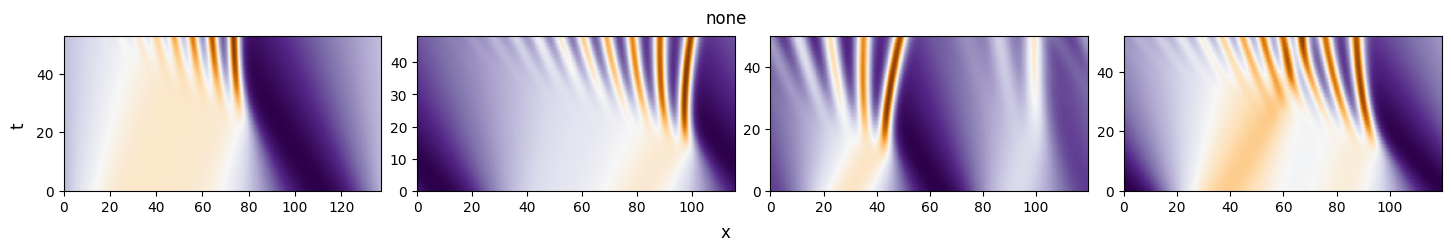

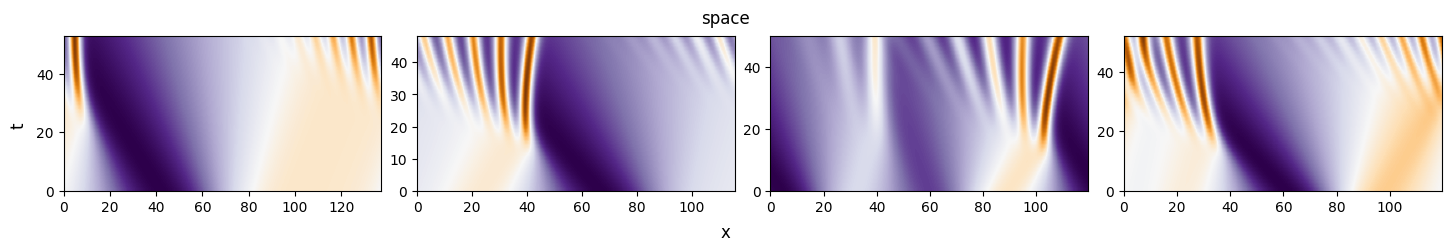

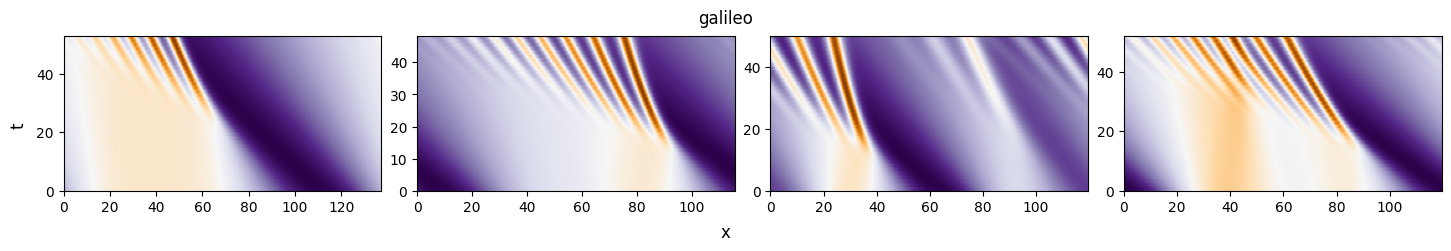

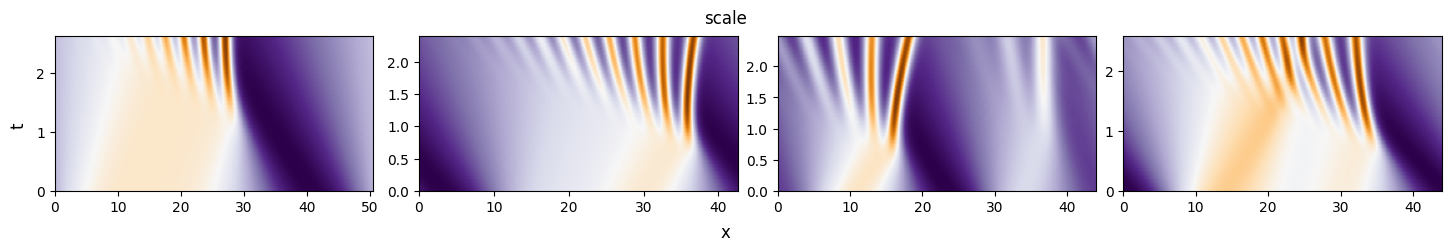

In [176]:
for augment, batch in batches.items():
    plot_1ds(*batch, nrows=1, ncols = len(us), l = 0.3, title = augment)

In [180]:
class NonEquivConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=40, out_channels=40, kernel_size=3, padding = 1, bias=True, padding_mode = 'circular')
    
    def forward(self, batch):
        us, dxs, dts = batch
        us = self.conv(us)
        return us, dxs, dts
    
conv = NonEquivConv()
conv.eval()

postprocess = lambda batch: batch[0]

for augment, augment_func in augments.items():
    print(f'\n{augment}')
    assert_equiv(batches['none'], conv, augment_func, rtol=1e-6, atol=1e-6, postprocess=postprocess, print_only=True);


none
Equivariance test passed.

space
Equivariance test passed.

galileo
Equivariance test failed. 
Max difference:  2.95627 
Mean difference: 0.562734

scale
Equivariance test failed. 
Max difference:  0.562213 
Mean difference: 0.318692


In [187]:
conv.conv.bias.data

tensor([-0.0784,  0.0699, -0.0623, -0.0834, -0.0278,  0.0880, -0.0399,  0.0381,
        -0.0403,  0.0454, -0.0489,  0.0430,  0.0375,  0.0680, -0.0396,  0.0231,
         0.0248,  0.0380, -0.0100, -0.0621, -0.0795,  0.0237, -0.0015, -0.0663,
         0.0724,  0.0426, -0.0385, -0.0551, -0.0333, -0.0603,  0.0871,  0.0467,
         0.0844,  0.0739,  0.0441,  0.0385, -0.0862, -0.0050,  0.0003, -0.0873])

In [186]:
conv.conv.weight.data.shape

torch.Size([40, 40, 3])

In [197]:
i

torch.Size([6, 2, 1, 5])

### Conv1d from scratch

In [248]:
batch = 4
in_channels = 6

groups = 3

kernel_size = 5
out_channels = 6

bias = torch.rand(out_channels)
inp = torch.randn(batch, in_channels, 1, 12)
w = torch.randn(out_channels, in_channels // groups, 1, kernel_size)

print(inp.shape, w.shape, bias.shape)

conv = nn.Conv1d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride=1)


torch.Size([4, 6, 1, 12]) torch.Size([6, 2, 1, 5]) torch.Size([6])


In [249]:
inp_unf = torch.nn.functional.unfold(inp.view(batch * groups, in_channels // groups, 1, 12), (1, kernel_size))
assert inp_unf.shape == (12,10,8)  #  = (12, 10, 8) = (..., kernel_size * in_channels // groups, conv output width)

out_unf = inp_unf.view(batch, groups, inp_unf.size(1), inp_unf.size(2)).transpose(2, 3).matmul(w.view(1, groups, out_channels // groups, -1).permute(0, 1, 3, 2)).transpose(2,3)
assert out_unf.shape == (batch, 3, 2, 8)

e_out = torch.nn.functional.conv2d(inp, w, bias=bias, groups=groups)
assert e_out.shape == (batch, out_channels, 1, 8)

e_out2 = out_unf.reshape(batch, out_channels, 1, inp_unf.size(2)) + bias.unsqueeze(0).unsqueeze(2).unsqueeze(3)
assert torch.allclose(e_out2, e_out, atol=1e-6, rtol=1e-6)

# (out_unf.reshape(batch, out_channels, 1, inp_unf.size(2)) + bias.unsqueeze(0).unsqueeze(2).unsqueeze(3) - e_out).abs().max()


In [252]:
e_out.shape

torch.Size([4, 6, 1, 8])

In [219]:
groups = 3
batch = 4
out_channels = 6
in_channels = 6
kernel = 5
bias = torch.rand(out_channels)
inp = torch.randn(batch, in_channels, 1, 12)
w = torch.randn(out_channels, in_channels // groups, 1, kernel)

inp_unf = torch.nn.functional.unfold(inp.view(batch * groups, in_channels // groups, 1, 12), (1, kernel))
# inp_unf.size()   # 10 is kernel * in_channels // groups, 8 is conv output width
# torch.Size([12, 10, 8])
out_unf = inp_unf.view(batch, groups, inp_unf.size(1), inp_unf.size(2)).transpose(2, 3).matmul(w.view(1, groups, out_channels // groups, -1).permute(0, 1, 3, 2)).transpose(2,3)
# out_unf.size()
# torch.Size([4, 3, 2, 8])
e_out = torch.nn.functional.conv2d(inp, w, bias=bias, groups=3)
# e_out.size()
# torch.Size([4, 6, 1, 8])
(out_unf.reshape(batch, out_channels, 1, inp_unf.size(2)) + bias.unsqueeze(0).unsqueeze(2).unsqueeze(3) - e_out).abs().max()
# tensor(4.7684e-07)

tensor(9.5367e-07)

In [230]:
m = nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 2, stride=1)

print(m.weight[0][0][0] , m.weight[0][0][1] , m.bias )

print(2 * m.weight[0][0][0] + 3* m.weight[0][0][1] +  m.bias  )
print(3 * m.weight[0][0][0] + 4* m.weight[0][0][1] +  m.bias  )

output = m(input)
print(output)

tensor(-0.3482, grad_fn=<SelectBackward0>) tensor(-0.1202, grad_fn=<SelectBackward0>) Parameter containing:
tensor([0.1145], requires_grad=True)
tensor([-0.9425], grad_fn=<AddBackward0>)
tensor([-1.4109], grad_fn=<AddBackward0>)
tensor([[[-0.9425, -1.4109]]], grad_fn=<ConvolutionBackward0>)


In [226]:
m = nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 1, stride=1)  

input = torch.tensor([[[2.,3.,4.,]]]) # batch, channel, width
print(input)

output = m(input)
print(output)

print(2 * m.weight + m.bias )
print(3 * m.weight + m.bias)
print(4 * m.weight + m.bias)

tensor([[[-0.2762, -0.6449]]], grad_fn=<ConvolutionBackward0>)


In [1]:
import torch 
from torch import nn
import torch.nn.functional as F

In [7]:
import torch

def custom_conv1d(input, weight, bias=None):
    """
    A simple implementation of 1D convolution.

    Parameters:
    input (Tensor): The input tensor of shape (N, channel_in, L)
    weight (Tensor): The weight tensor of shape (channel_out, channel_in, kernel_size)
    bias (Tensor, optional): The bias tensor of shape (channel_out)

    Returns:
    Tensor: The result of the convolution operation.
    """
    batch_size, channel_in, space_len = input.shape
    channel_out, _, kernel_size = weight.shape

    # Calculate padding size for circular padding
    pad_size = kernel_size - 1

    # Pad the input tensor circularly
    padded_input = torch.cat([input[:, :, -pad_size:], input, input[:, :, :pad_size]], dim=2)

    # Output length
    space_len_out = space_len + pad_size

    # Initialize output tensor
    output = torch.zeros((batch_size, channel_out, space_len_out))

    # Perform the convolution operation
    for i in range(space_len_out):
        # Extract the current slice of the input for convolution
        input_slice = padded_input[:, :, i:i+kernel_size]

        # Perform convolution (matrix multiplication and sum)
        # for each output channel
        for j in range(channel_out):
            output[:, j, i] = torch.sum(input_slice * weight[j, :, :], dim=(1, 2))

    # Trim the circular padding off the output to get the original length
    output = output[:, :, pad_size:-pad_size]

    # Add bias if provided
    if bias is not None:
        output += bias.unsqueeze(1).expand_as(output)

    return output

# Example usage
batch_size, channel_in, space_len = 1, 10, 10  # Batch size, channels in, length of input
channel_out, kernel_size = 10, 3       # Channels out, kernel size

# Random tensors for input, weights, and bias
input_tensor = torch.randn(batch_size, channel_in, space_len)
weight_tensor = torch.randn(channel_out, channel_in, kernel_size)
bias_tensor = torch.randn(channel_out)

# Perform the convolution
output1 = custom_conv1d(input_tensor, weight_tensor, bias_tensor)
output1.shape  # Should be (batch_size, channel_out, L_out)

m = nn.Conv1d(in_channels = channel_in, out_channels = channel_out, kernel_size = kernel_size, stride=1, padding_mode = 'circular')
m.weight.data = weight_tensor
m.bias.data = bias_tensor

output2 = m(input_tensor)
diff = torch.abs(output1 - output2)
print(diff.max())  # Should be very small
print(diff.mean())  # Should be very small

torch.allclose(output1, output2, atol=1e-6, rtol=1e-6)


tensor(1.9073e-06, grad_fn=<MaxBackward1>)
tensor(3.6452e-07, grad_fn=<MeanBackward0>)


True

In [ ]:
def custom_conv1d_circular_vectorized(input, weight, bias=None):
    """
    A vectorized implementation of 1D convolution with circular padding.

    Parameters:
    input (Tensor): The input tensor of shape (N, C_in, L)
    weight (Tensor): The weight tensor of shape (C_out, C_in, K)
    bias (Tensor, optional): The bias tensor of shape (C_out)

    Returns:
    Tensor: The result of the convolution operation.
    """
    N, C_in, L = input.shape
    C_out, _, K = weight.shape

    # Calculate padding size and apply circular padding
    pad_size = K - 1
    padded_input = F.pad(input, (pad_size, pad_size), mode='circular')


    # Create unfolded input tensor manually
    windows = [padded_input[:, :, i:i + K] for i in range(L)]
    unfolded = torch.stack(windows, dim=2)

    # Reshape weight for batched matrix multiplication
    weight_reshaped = weight.view(C_out, -1)

    # Perform convolution using matrix multiplication
    output = torch.matmul(weight_reshaped, unfolded.view(N, -1, L)).view(N, C_out, L)

    # Add bias if provided
    if bias is not None:
        output += bias.view(1, -1, 1)

    return output

In [6]:


# Example usage
batch_size, channel_in, space_len = 1, 2, 10  # Batch size, channels in, length of input
channel_out, kernel_size = 2, 3       # Channels out, kernel size

# Random tensors for input, weights, and bias
input_tensor = torch.randn(batch_size, channel_in, space_len)
weight_tensor = torch.randn(channel_out, channel_in, kernel_size)
bias_tensor = torch.randn(channel_out)

# Perform the convolution with circular padding (vectorized)
# output1 = custom_conv1d_circular_vectorized(input_tensor, weight_tensor, bias_tensor)


# Calculate padding size and apply circular padding
pad_size = kernel_size - 1
padded_input = F.pad(input_tensor, (pad_size, pad_size), mode='circular')

# Create unfolded input tensor manually
windows = [padded_input[:, :, i:i + kernel_size] for i in range(space_len)]
unfolded = torch.stack(windows, dim=2)

# Reshape weight for batched matrix multiplication
weight_reshaped = weight_tensor.view(channel_out, -1)

# Perform convolution using matrix multiplication
output = torch.matmul(weight_reshaped, unfolded.view(batch_size, -1, space_len)).view(batch_size, channel_out, space_len)

# Add bias if provided
# if bias is not None:
output += bias_tensor.view(1, -1, 1)

output = output1



assert output1.shape == (batch_size, channel_out, space_len)   # Should be (N, C_out, L)

m = nn.Conv1d(in_channels = channel_in, out_channels = channel_out, kernel_size = kernel_size, stride=1, padding = 1, padding_mode='circular')
# print(m.weight.data.shape, weight_tensor.shape)
# print(m.bias.data.shape, bias_tensor.shape)
m.weight.data = weight_tensor
m.bias.data = bias_tensor

output2 = m(input_tensor)
assert output2.shape == (batch_size, channel_out, space_len), output2.shape

diff = torch.abs(output1 - output2)
print(diff.max())  # Should be very small
print(diff.mean())  # Should be very small

torch.allclose(output1, output2, atol=1e-6, rtol=1e-6)


AssertionError: 

In [52]:
unfolded

tensor([[[[-1.7828, -0.9790,  1.1085],
          [-0.9790,  1.1085, -1.7943],
          [ 1.1085, -1.7943, -0.6440],
          [-1.7943, -0.6440,  0.7862],
          [-0.6440,  0.7862,  1.5319],
          [ 0.7862,  1.5319,  0.4247],
          [ 1.5319,  0.4247, -0.5154],
          [ 0.4247, -0.5154, -0.4778],
          [-0.5154, -0.4778, -1.7828],
          [-0.4778, -1.7828, -0.9790]],

         [[-0.1405, -0.5443,  0.0264],
          [-0.5443,  0.0264,  2.0317],
          [ 0.0264,  2.0317, -1.0914],
          [ 2.0317, -1.0914,  0.3616],
          [-1.0914,  0.3616,  0.7890],
          [ 0.3616,  0.7890,  1.0806],
          [ 0.7890,  1.0806, -0.5597],
          [ 1.0806, -0.5597, -0.2971],
          [-0.5597, -0.2971, -0.1405],
          [-0.2971, -0.1405, -0.5443]],

         [[-0.2128, -0.1324, -1.5752],
          [-0.1324, -1.5752, -0.1079],
          [-1.5752, -0.1079,  1.7025],
          [-0.1079,  1.7025, -1.6703],
          [ 1.7025, -1.6703,  0.8987],
          [-1.6703,  

In [51]:
unfolded.view(batch_size, -1, space_len)

tensor([[[-1.7828, -0.9790,  1.1085, -0.9790,  1.1085, -1.7943,  1.1085,
          -1.7943, -0.6440, -1.7943],
         [-0.6440,  0.7862, -0.6440,  0.7862,  1.5319,  0.7862,  1.5319,
           0.4247,  1.5319,  0.4247],
         [-0.5154,  0.4247, -0.5154, -0.4778, -0.5154, -0.4778, -1.7828,
          -0.4778, -1.7828, -0.9790],
         [-0.1405, -0.5443,  0.0264, -0.5443,  0.0264,  2.0317,  0.0264,
           2.0317, -1.0914,  2.0317],
         [-1.0914,  0.3616, -1.0914,  0.3616,  0.7890,  0.3616,  0.7890,
           1.0806,  0.7890,  1.0806],
         [-0.5597,  1.0806, -0.5597, -0.2971, -0.5597, -0.2971, -0.1405,
          -0.2971, -0.1405, -0.5443],
         [-0.2128, -0.1324, -1.5752, -0.1324, -1.5752, -0.1079, -1.5752,
          -0.1079,  1.7025, -0.1079],
         [ 1.7025, -1.6703,  1.7025, -1.6703,  0.8987, -1.6703,  0.8987,
          -2.1760,  0.8987, -2.1760],
         [-0.0119, -2.1760, -0.0119, -0.3083, -0.0119, -0.3083, -0.2128,
          -0.3083, -0.2128, -0.1324]]])

In [49]:
weight_tensor

tensor([[[ 1.6416, -0.8338, -0.6618],
         [ 0.3980, -0.6288,  1.8429],
         [-1.1341, -1.1998, -0.6697]],

        [[-0.5490,  1.2674,  0.0521],
         [-0.1750, -1.8503,  1.6961],
         [-1.7823, -0.2367,  0.3404]]])

In [50]:
weight_reshaped

tensor([[ 1.6416, -0.8338, -0.6618,  0.3980, -0.6288,  1.8429, -1.1341, -1.1998,
         -0.6697],
        [-0.5490,  1.2674,  0.0521, -0.1750, -1.8503,  1.6961, -1.7823, -0.2367,
          0.3404]])

In [40]:
print(padded_input.shape)
padded_input

torch.Size([1, 2, 14])


tensor([[[ 0.9651, -0.0109,  1.2287, -1.7540,  0.9904,  0.2414, -0.2145,
          -0.9892, -0.7957, -0.6536,  0.9651, -0.0109,  1.2287, -1.7540],
         [-2.5831,  0.1745, -0.3913, -2.5389,  2.0688, -0.3522,  1.0235,
           0.5042,  0.1013, -0.0194, -2.5831,  0.1745, -0.3913, -2.5389]]])

In [41]:
F.pad(input_tensor, (pad_size, pad_size))

tensor([[[ 0.0000,  0.0000,  1.2287, -1.7540,  0.9904,  0.2414, -0.2145,
          -0.9892, -0.7957, -0.6536,  0.9651, -0.0109,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.3913, -2.5389,  2.0688, -0.3522,  1.0235,
           0.5042,  0.1013, -0.0194, -2.5831,  0.1745,  0.0000,  0.0000]]])

In [2]:
import torch

def custom_conv1d(input, weight, bias=None):
    """
    A simple implementation of 1D convolution.

    Parameters:
    input (Tensor): The input tensor of shape (N, channel_in, L)
    weight (Tensor): The weight tensor of shape (channel_out, channel_in, kernel_size)
    bias (Tensor, optional): The bias tensor of shape (channel_out)

    Returns:
    Tensor: The result of the convolution operation.
    """
    batch_size, channel_in, space_len = input.shape
    channel_out, _, kernel_size = weight.shape

    # Calculate padding size for circular padding
    pad_size = kernel_size - 1

    # Pad the input tensor circularly
    padded_input = torch.cat([input[:, :, -pad_size:], input, input[:, :, :pad_size]], dim=2)

    # Output length
    space_len_out = space_len + pad_size

    # Initialize output tensor
    output = torch.zeros((batch_size, channel_out, space_len_out))

    # Perform the convolution operation
    for i in range(space_len_out):
        # Extract the current slice of the input for convolution
        input_slice = padded_input[:, :, i:i+kernel_size]

        # Perform convolution (matrix multiplication and sum)
        # for each output channel
        for j in range(channel_out):
            output[:, j, i] = torch.sum(input_slice * weight[j, :, :], dim=(1, 2))

    # Trim the circular padding off the output to get the original length
    output = output[:, :, pad_size:-pad_size]

    # Add bias if provided
    if bias is not None:
        output += bias.unsqueeze(1).expand_as(output)

    return output

# Example usage
batch_size, channel_in, space_len = 1, 10, 10  # Batch size, channels in, length of input
channel_out, kernel_size = 10, 3       # Channels out, kernel size

# Random tensors for input, weights, and bias
input_tensor = torch.randn(batch_size, channel_in, space_len)
weight_tensor = torch.randn(channel_out, channel_in, kernel_size)
bias_tensor = torch.randn(channel_out)

# Perform the convolution
output1 = custom_conv1d(input_tensor, weight_tensor, bias_tensor)
output1.shape  # Should be (batch_size, channel_out, L_out)

m = nn.Conv1d(in_channels = channel_in, out_channels = channel_out, kernel_size = kernel_size, stride=1, padding_mode = 'circular')
m.weight.data = weight_tensor
m.bias.data = bias_tensor

output2 = m(input_tensor)
diff = torch.abs(output1 - output2)
print(diff.max())  # Should be very small
print(diff.mean())  # Should be very small

torch.allclose(output1, output2, atol=1e-6, rtol=1e-6)


tensor(3.8147e-06, grad_fn=<MaxBackward1>)
tensor(5.0701e-07, grad_fn=<MeanBackward0>)


True

In [3]:
import torch
import torch.nn.functional as F

def custom_conv1d(input_tensor, kernel, stride=1, padding=0):
    """
    Perform 1D convolution on an input tensor without using any for loops.

    Args:
    input_tensor (torch.Tensor): The input tensor.
    kernel (torch.Tensor): The convolution kernel.
    stride (int): The stride of the convolution.
    padding (int): The amount of zero padding added to both sides of the input.

    Returns:
    torch.Tensor: The result of the convolution.
    """

    # Add padding to the input tensor
    if padding > 0:
        input_tensor = F.pad(input_tensor, (padding, padding))

    # Unfold the input tensor to create sliding windows
    unfolded = input_tensor.unfold(dimension=-1, size=kernel.size(-1), step=stride)

    # Perform convolution
    output = (unfolded * kernel).sum(dim=-1)

    return output

# Example usage
input_tensor = torch.tensor([[[1., 2., 3., 4., 5., 6., 7.]]])
kernel = torch.tensor([[[1., 0., -1.]]])

output = custom_conv1d(input_tensor, kernel, stride=1, padding=1)
output


tensor([[[-2., -2., -2., -2., -2., -2.,  6.]]])

In [4]:
input_tensor.shape

torch.Size([1, 1, 7])

In [ ]:
string

In [203]:
def all_close_flat(a, b):
    return torch.allclose(a.flatten(), b.flatten(), atol=1e-6, rtol=1e-6), (a - b)

def check(a, b, string):
    print(string, a.shape)
    print(len(string) * ' ', b.shape)
    all_close_flat(a, b)

In [226]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

channel_in, channel_out = 1, 2
img = x = torch.randn(1, channel_in, 1, 32)
img1d = img.squeeze(2)
batch_size, channels, h, w = img.shape

# setup the parameters for Conv2d

kh, kw = 1, 3 # kernel size
dh, dw = 1, 1 # stride

# Create conv
conv1d = nn.Conv1d(channel_in, channel_out, kw, stride=dw, bias=False)
conv2d = nn.Conv2d(channel_in, channel_out, (kh, kw), stride=(dh, dw), bias=False)
conv1d.weight.data = conv2d.weight.squeeze(2)

conv_weight = conv2d.weight
conv_weight1d = conv1d.weight
true_conv2d = conv2d(img)
true_conv1d = conv1d(img1d)
check(true_conv2d, true_conv1d, 'True conv shape: ')

patches = img.unfold(2, kh, dh)
patches1d = img1d.unsqueeze(2).unsqueeze(4)
patches = patches.unfold(3, kw, dw)
patches1d = img1d.unsqueeze(2).unfold(3, kw, dw)
check(patches, patches1d, 'Patches unfold shape: ')

patches = patches.contiguous().view(batch_size, channels, -1, kh, kw)
patches1d = patches1d.contiguous().view(batch_size, channels, -1, kw)
# batch_size, channels, windows, kh, kw
check(patches, patches1d, 'Patches contiguous shape: ')

nb_windows = patches.size(2)
# Shift the windows into the batch dimension using permute
patches   = patches.permute(0, 2, 1, 3, 4)
patches1d = patches1d.permute(0, 2, 1, 3)
# batch_size, nb_windows, channels, kh, kw
check(patches, patches1d, 'Patches permutation shape: ')

# Multiply the patches with the weights in order to calculate the conv
result = (patches.unsqueeze(2) * conv_weight.unsqueeze(0).unsqueeze(1)).sum([3, 4, 5])
result1d = (patches1d.unsqueeze(2) * conv_weight1d.unsqueeze(0)).sum([3, 4])
check(result, result1d, 'After conv operation: ')

result = result.permute(0, 2, 1) # batch_size, out_channels, output_pixels
result1d = result1d.permute(0, 2, 1) # batch_size, out_channels, output_pixels
check(result, result1d, 'After permutation: ')

# assuming h = w
h_unpadded = h - kh + 1
w_unpadded = w - kw + 1

result = result.view(batch_size, channel_out, h_unpadded, w_unpadded)
result1d = result1d.view(batch_size, channel_out, w_unpadded)
check(result, result1d, 'After view: ')



torch.allclose(result, true_conv2d, atol=1e-6, rtol=1e-6)
torch.allclose(result1d, true_conv1d, atol=1e-6, rtol=1e-6)

# for true_conv in [true_conv2d]:
#     print('Result shape: ', result.shape, ' Actual shape:', true_conv.shape)
#     # Verify the error between actual and result
#     error = (true_conv - result).abs().max().item()
#     print('Max Absolute Error : ', error)

#     torch.allclose(true_conv, result, atol=1e-6, rtol=1e-6)

True conv shape:  torch.Size([1, 2, 1, 30])
                  torch.Size([1, 2, 30])
Patches unfold shape:  torch.Size([1, 1, 1, 30, 1, 3])
                       torch.Size([1, 1, 1, 30, 3])
Patches contiguous shape:  torch.Size([1, 1, 30, 1, 3])
                           torch.Size([1, 1, 30, 3])
Patches permutation shape:  torch.Size([1, 30, 1, 1, 3])
                            torch.Size([1, 30, 1, 3])
After conv operation:  torch.Size([1, 30, 2])
                       torch.Size([1, 30, 2])
After permutation:  torch.Size([1, 2, 30])
                    torch.Size([1, 2, 30])
After view:  torch.Size([1, 2, 1, 30])
             torch.Size([1, 2, 30])


True

In [232]:



# Multiply the patches with the weights in order to calculate the conv
result = (patches.unsqueeze(2) * conv_weight.unsqueeze(0).unsqueeze(1)).sum([3, 4, 5])
result1d = (patches1d.unsqueeze(2) * conv_weight1d.unsqueeze(0)).sum([3, 4])
check(result, result1d, 'After conv operation: ')
# all_close_flat(result, result1d)
# batch_size, output_pixels, out_channels
# print('After conv operation', result.shape)
# print('After conv operation', result1d.shape)
result = result.permute(0, 2, 1) # batch_size, out_channels, output_pixels
result1d = result1d.permute(0, 2, 1) # batch_size, out_channels, output_pixels
check(result, result1d, 'After permutation: ')
# print('After permutation', result.shape)
# print('After permutation', result1d.shape)
# all_close_flat(result, result1d)

# assuming h = w
h_unpadded = h - kh + 1
w_unpadded = w - kw + 1

result = result.view(batch_size, channel_out, h_unpadded, w_unpadded)
result1d = result1d
print('After reshape', result.shape)
print('After reshape', result1d.shape)


true_conv1d = true_conv1d.unsqueeze(1)
print('True conv shape: ', true_conv2d.shape)
print('True conv shape: ', true_conv1d.shape)


for true_conv in [true_conv1d, true_conv2d]:


    print('Result shape: ', result.shape, ' Actual shape:', true_conv.shape)
    # Verify the error between actual and result
    error = (true_conv - result).abs().max().item()
    print('Max Absolute Error : ', error)

    torch.allclose(true_conv, result, atol=1e-6, rtol=1e-6)

After conv operation:  torch.Size([1, 30, 2])
                       torch.Size([1, 30, 2])
After permutation:  torch.Size([1, 2, 30])
                    torch.Size([1, 2, 30])
After reshape torch.Size([1, 2, 1, 30])
After reshape torch.Size([1, 2, 30])
True conv shape:  torch.Size([1, 2, 1, 30])
True conv shape:  torch.Size([1, 1, 1, 2, 30])
Result shape:  torch.Size([1, 2, 1, 30])  Actual shape: torch.Size([1, 1, 1, 2, 30])
Max Absolute Error :  2.1787233352661133
Result shape:  torch.Size([1, 2, 1, 30])  Actual shape: torch.Size([1, 2, 1, 30])
Max Absolute Error :  1.1920928955078125e-07


In [128]:
h_unpadded

1

In [103]:
conv2d.weight, conv1d.weight

(Parameter containing:
 tensor([[[[-0.1570,  0.0413,  0.3720]]]], requires_grad=True),
 Parameter containing:
 tensor([[[-0.1570,  0.0413,  0.3720]]], requires_grad=True))

In [102]:
conv1d.weight.data = conv2d.weight.squeeze(2)

In [95]:
conv2d.weight

Parameter containing:
tensor([[[[0.4077, 0.5356, 0.5595]]]], requires_grad=True)

In [82]:
conv_weight

Parameter containing:
tensor([[[[0.4077, 0.5356, 0.5595]]]], requires_grad=True)

In [234]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

channel_in, channel_out = 1, 2
img = x = torch.randn(1, channel_in, 1, 32)
img1d = img.squeeze(2)
batch_size, channels, h, w = img.shape

# setup the parameters for Conv2d

kh, kw = 1, 3 # kernel size
dh, dw = 1, 1 # stride

# Create conv
conv1d = nn.Conv1d(channel_in, channel_out, kw, stride=dw, bias=False)

conv_weight1d = conv1d.weight
true_conv1d = conv1d(img1d)

patches1d = img1d.unsqueeze(2).unsqueeze(4)
patches1d = img1d.unsqueeze(2).unfold(3, kw, dw)

patches1d = patches1d.contiguous().view(batch_size, channels, -1, kw)

nb_windows = patches.size(2)
# Shift the windows into the batch dimension using permute
patches1d = patches1d.permute(0, 2, 1, 3) # # batch_size, nb_windows, channels, kw

# Multiply the patches with the weights in order to calculate the conv
result1d = (patches1d.unsqueeze(2) * conv_weight1d.unsqueeze(0)).sum([3, 4])

result1d = result1d.permute(0, 2, 1) # batch_size, out_channels, output_pixels
check(result, result1d, 'After permutation: ')

w_unpadded = w - kw + 1

result1d = result1d.view(batch_size, channel_out, w_unpadded)

torch.allclose(result1d, true_conv1d)#, atol=1e-6, rtol=1e-6)


After permutation:  torch.Size([1, 2, 1, 30])
                    torch.Size([1, 2, 30])


True